# FPH annual report probability visualisation
This notebook loads Fisher & Paykel Healthcare (FPH) annual report BERT outputs (finance, social, env, maori probabilities), combines them with a year column, and plots trends of how often each label is predicted strongly at three thresholds: >0.5, >0.75, >0.95.


In [28]:
# One-time install of plotting libraries (uncomment if needed)
%pip install -q matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

CODE_PREFIX = "FPH"

data_dir = Path("data")
csv_paths = sorted(data_dir.glob(f"preds-FPH*.csv"))
page_counts_path = Path("outputs/page_counts.csv")

csv_paths


[PosixPath('data/preds-FPH2010.csv'),
 PosixPath('data/preds-FPH2011.csv'),
 PosixPath('data/preds-FPH2012.csv'),
 PosixPath('data/preds-FPH2013.csv'),
 PosixPath('data/preds-FPH2014.csv'),
 PosixPath('data/preds-FPH2015.csv'),
 PosixPath('data/preds-FPH2016.csv'),
 PosixPath('data/preds-FPH2017.csv'),
 PosixPath('data/preds-FPH2018.csv'),
 PosixPath('data/preds-FPH2019.csv'),
 PosixPath('data/preds-FPH2020.csv'),
 PosixPath('data/preds-FPH2021.csv'),
 PosixPath('data/preds-FPH2022.csv'),
 PosixPath('data/preds-FPH2023.csv'),
 PosixPath('data/preds-FPH2024.csv'),
 PosixPath('data/preds-FPH2025.csv')]

In [30]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    frames = []
    for path in paths:
        year = int(path.stem.replace(f"preds-{CODE_PREFIX}", ""))
        df = pd.read_csv(path)
        df["year"] = year
        df["word_count"] = df["sentence"].fillna("").str.split().str.len()
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def load_page_counts(path):
    if not path.exists():
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts = pd.read_csv(path)
    required_cols = {"code_year", "pages"}
    missing_cols = required_cols - set(page_counts.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in page counts file: {missing_cols}")
    page_counts = page_counts[page_counts["code_year"].astype(str).str.startswith(CODE_PREFIX)]
    if page_counts.empty:
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts["year"] = page_counts["code_year"].str.extract(r"(\d{4})").astype(int)
    page_counts = page_counts[["year", "pages"]].rename(columns={"pages": "page_count"})
    return page_counts

# Run scripts/page_counts.py to generate outputs/page_counts.csv from PDFs in reports/
page_counts = load_page_counts(page_counts_path)

df = load_yearly(csv_paths)
df.head()


,sentence,source_page,source_pdf,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label,year,word_count
0,Annual Report 2010 Generating value through innovation,1,FPH2010,0.867026,0.043074,0.088660,0.000086,2010,7
1,Our Vision and Values 2 Results in Brief 4 2010 Highlights 5 Chairman’s Report 6 Chief Executive Officer’s Review 10...,2,FPH2010,0.001883,0.979639,0.049713,0.001121,2010,79
2,Our consistent growth strategy is to provide an expanding range of innovative medical devices which can help to impr...,3,FPH2010,0.015384,0.998315,0.000631,0.001916,2010,30
3,fisher & paykel healthcare corporation limited – annual report 2010 2 | Vision Our purpose is to increase shareholde...,4,FPH2010,0.067230,0.995086,0.000513,0.001017,2010,37
4,| 3 fisher & paykel healthcare corporation limited – annual report 2010 Values Patients We will employ our research ...,5,FPH2010,0.005689,0.998186,0.001136,0.001846,2010,46


In [31]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


,year,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label
count,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000
mean,2018.711720,0.340526,0.430646,0.234180,0.010440
std,4.615925,0.439264,0.459922,0.383946,0.088844
min,2010.000000,0.000242,0.000132,0.000107,0.000060
25%,2015.000000,0.004097,0.002544,0.001954,0.000800
50%,2019.000000,0.016301,0.099889,0.006769,0.001495
75%,2023.000000,0.957243,0.992109,0.302090,0.002303
max,2025.000000,0.999642,0.999373,0.999556,0.999433


In [32]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(
    id_vars=["year", "word_count"],
    value_vars=prob_cols,
    var_name="label",
    value_name="probability"
)
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


,year,word_count,label,probability
0,2010,7,FIN,0.867026
1,2010,79,FIN,0.001883
2,2010,30,FIN,0.015384
3,2010,37,FIN,0.067230
4,2010,46,FIN,0.005689


In [33]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
def summarize_over_threshold(df_long, threshold):
    over_mask = df_long["probability"] > threshold
    enriched = df_long.assign(
        over=over_mask,
        over_word_count=lambda d: d["word_count"].where(over_mask, 0)
    )
    agg = (
        enriched
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            total_words=("word_count", "sum"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total sentences
            over_word_count=("over_word_count", "sum"),
            mean_prob_over=("probability", lambda s: s[s > threshold].mean()),
        )
        .reset_index()
    )
    agg = agg.merge(page_counts, on="year", how="left")
    agg["page_count"] = agg["page_count"].replace({0: pd.NA})
    agg["over_sentence_word_share"] = agg["over_count"] / agg["total_words"]
    agg["over_word_share"] = agg["over_word_count"] / agg["total_words"]
    agg["sentences_per_page"] = agg["total_sentences"] / agg["page_count"]
    agg["over_sentences_per_page"] = agg["over_count"] / agg["page_count"]
    agg["over_words_per_page"] = agg["over_word_count"] / agg["page_count"]
    agg["threshold"] = threshold
    return agg


thresholds = [0.5, 0.75, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the 0.5 summary
summaries[0.5].head()


,year,label,total_sentences,total_words,over_count,over_share,over_word_count,mean_prob_over,page_count,over_sentence_word_share,over_word_share,sentences_per_page,over_sentences_per_page,over_words_per_page,threshold
0,2010,ENV,851,23559,203,0.238543,6112,0.902339,105,0.008617,0.259434,8.104762,1.933333,58.209524,0.5
1,2010,FIN,851,23559,372,0.437133,10809,0.940800,105,0.015790,0.458806,8.104762,3.542857,102.942857,0.5
2,2010,MAORI,851,23559,0,0.000000,0,NaN,105,0.000000,0.000000,8.104762,0.000000,0.000000,0.5
3,2010,SOC,851,23559,273,0.320799,6646,0.934397,105,0.011588,0.282100,8.104762,2.600000,63.295238,0.5
4,2011,ENV,906,24385,194,0.214128,5617,0.873242,108,0.007956,0.230347,8.388889,1.796296,52.009259,0.5


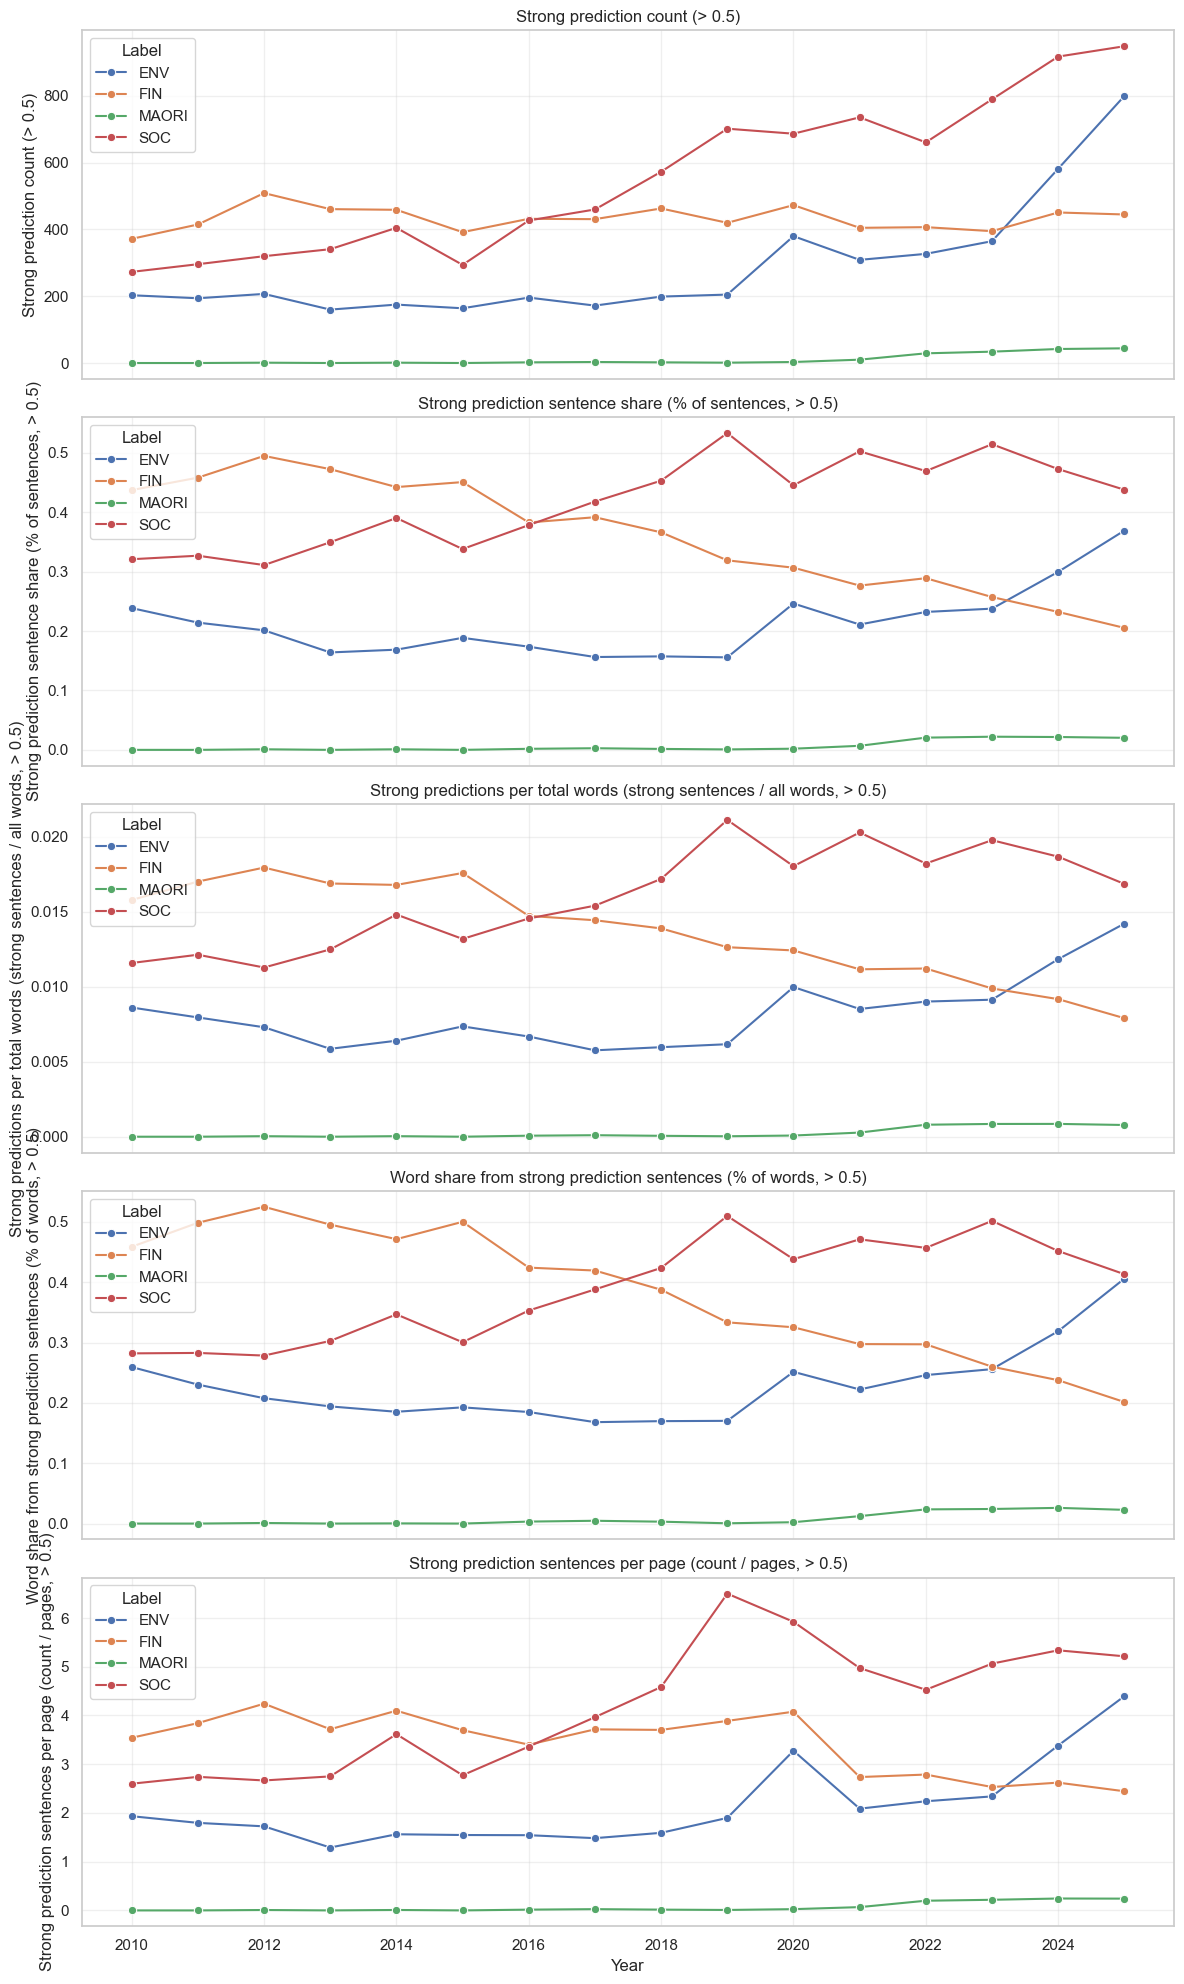

In [34]:
# Combined view for threshold > 0.5 (counts, shares)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.5)"),
    ("over_share", "Strong prediction sentence share (% of sentences, > 0.5)"),
    ("over_sentence_word_share", "Strong predictions per total words (strong sentences / all words, > 0.5)"),
    ("over_word_share", "Word share from strong prediction sentences (% of words, > 0.5)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (count / pages, > 0.5)"),
]
summary = summaries[0.5]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


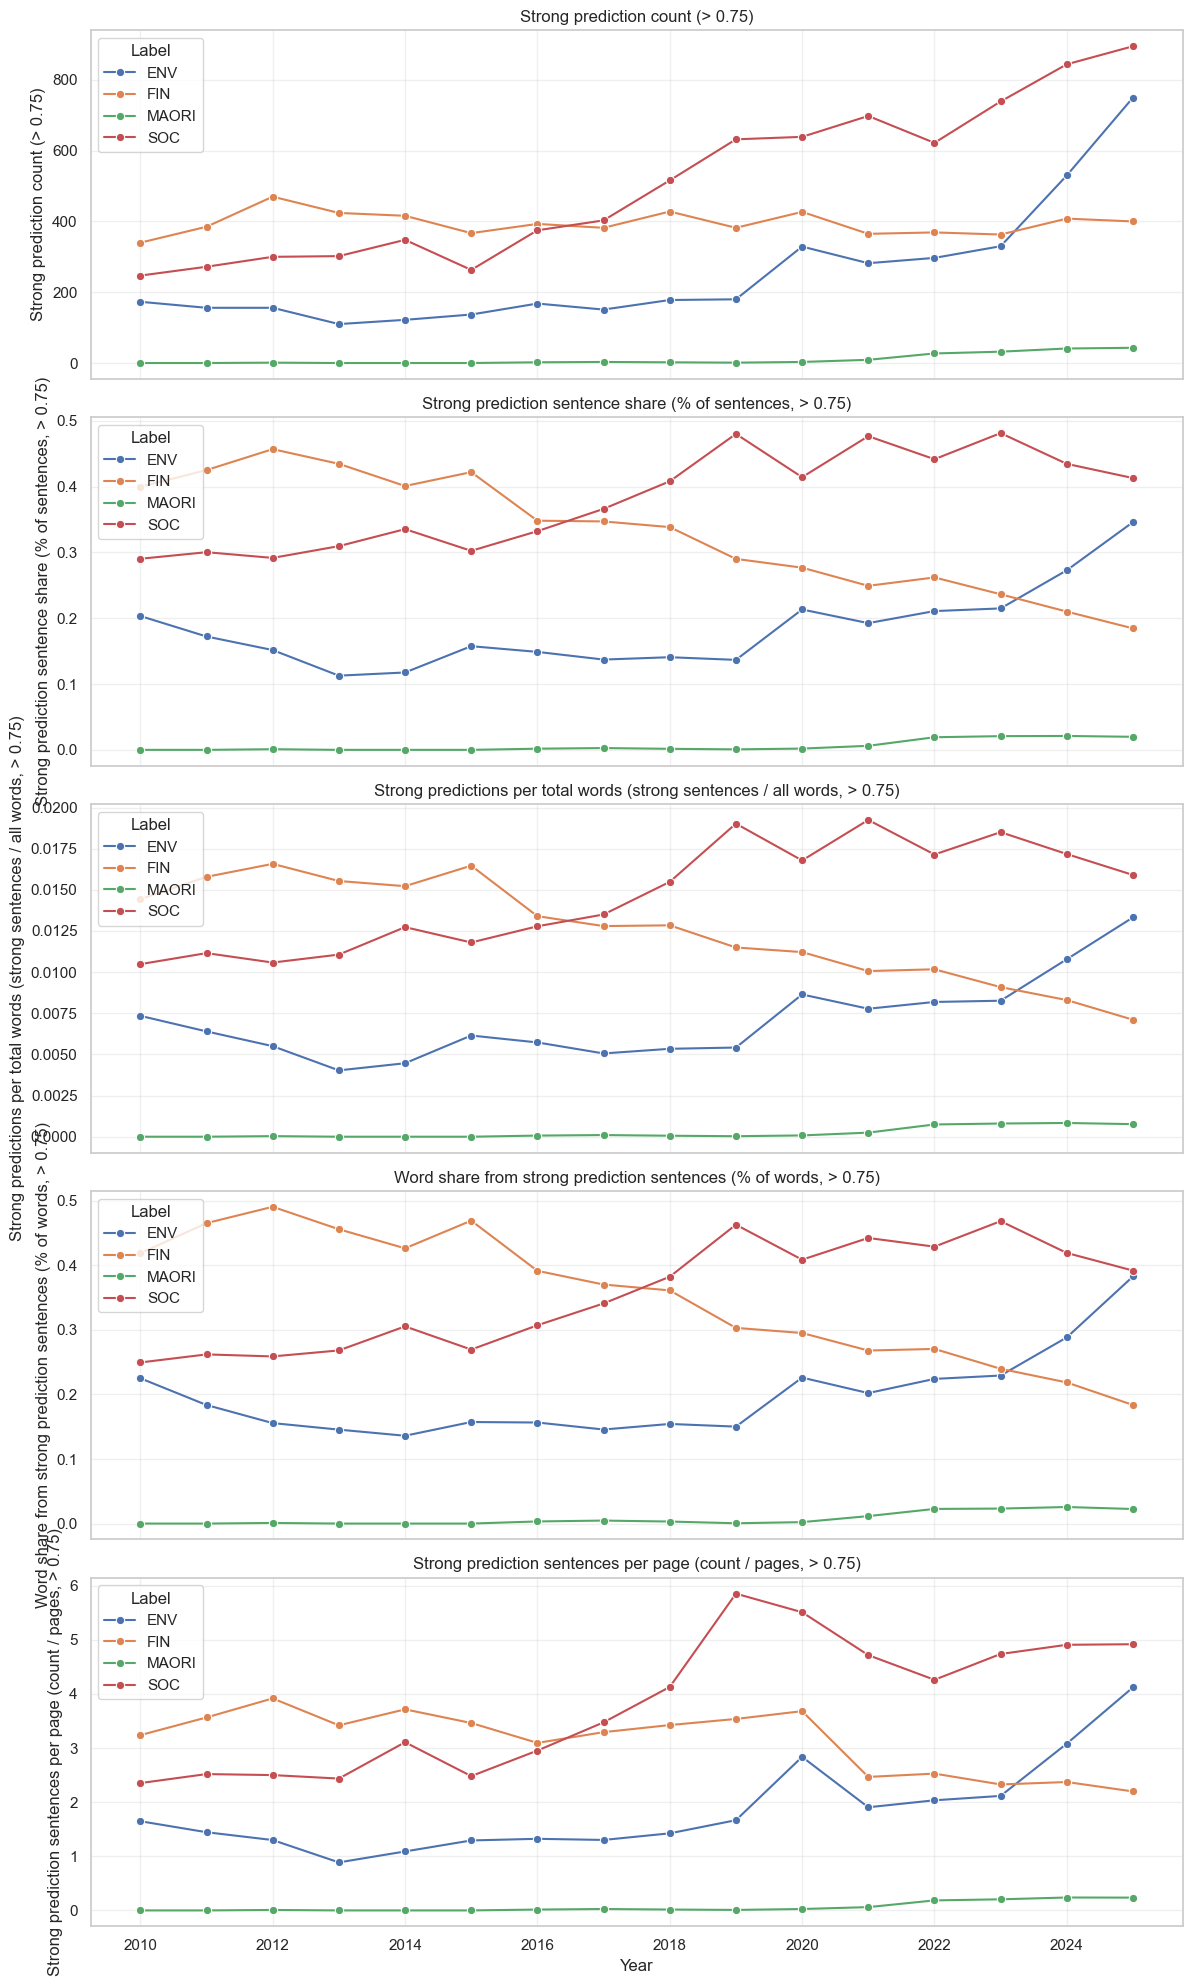

In [35]:
# Combined view for threshold > 0.75 (counts, shares)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.75)"),
    ("over_share", "Strong prediction sentence share (% of sentences, > 0.75)"),
    ("over_sentence_word_share", "Strong predictions per total words (strong sentences / all words, > 0.75)"),
    ("over_word_share", "Word share from strong prediction sentences (% of words, > 0.75)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (count / pages, > 0.75)"),
]
summary = summaries[0.75]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


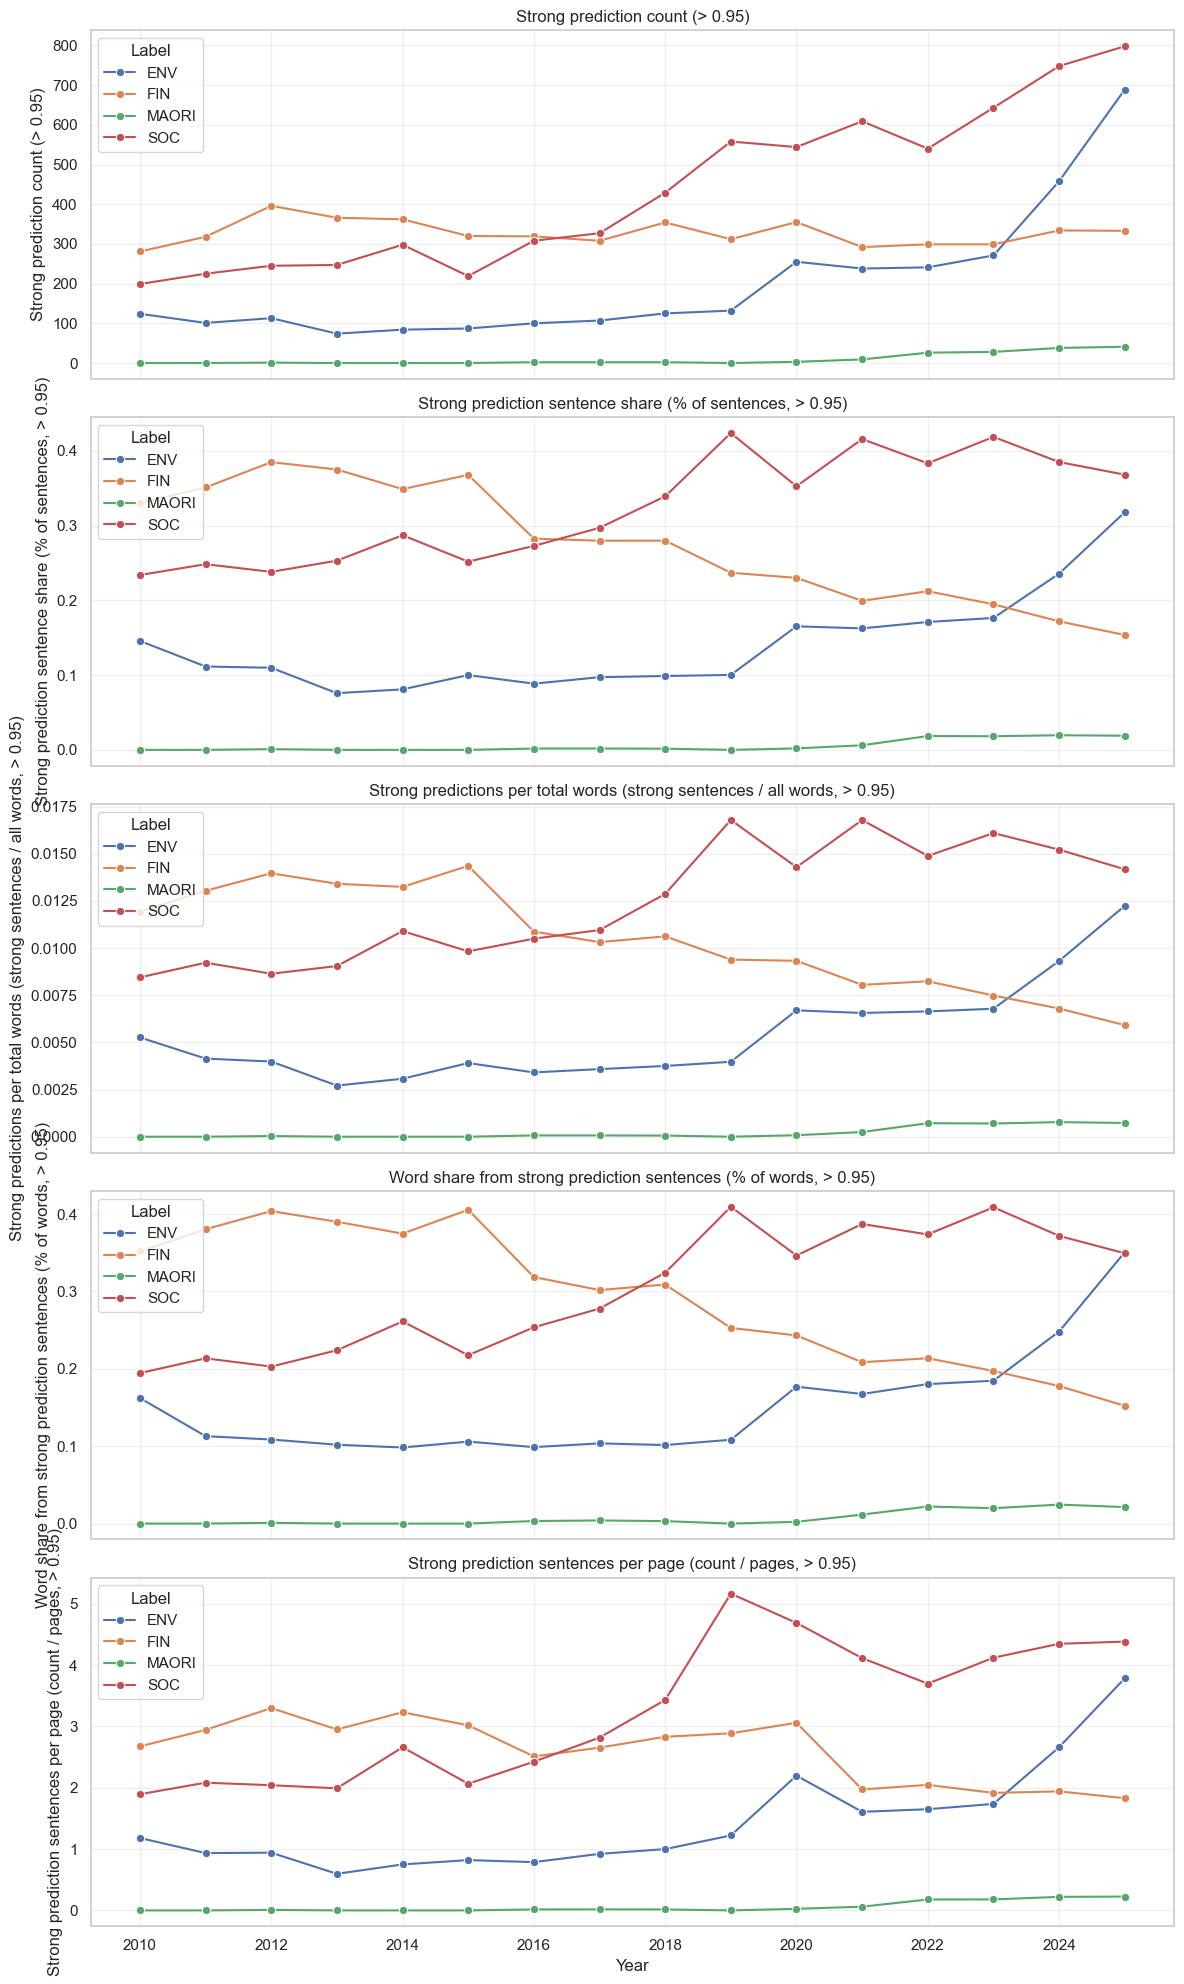

In [36]:
# Combined view for threshold > 0.95 (counts, shares)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.95)"),
    ("over_share", "Strong prediction sentence share (% of sentences, > 0.95)"),
    ("over_sentence_word_share", "Strong predictions per total words (strong sentences / all words, > 0.95)"),
    ("over_word_share", "Word share from strong prediction sentences (% of words, > 0.95)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (count / pages, > 0.95)"),
]
summary = summaries[0.95]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- over_sentence_word_share: strong prediction sentences divided by total words in that year+label grouping.
- over_word_share: total words from strong prediction sentences divided by total words for that year+label grouping.
- over_sentences_per_page: strong prediction sentences divided by page count for that year (requires outputs/page_counts.csv).
- over_words_per_page: total words from strong prediction sentences divided by page count for that year (requires outputs/page_counts.csv).
- mean_prob_over: average probability for those sentences above the threshold (NaN if none above threshold).
